### Glacier Ice and Snow Calculator.

Steps for the initial part of the project:-
1 - Gather Satellite images of a glacier mountainscape (Kenai Mountains) - Using Landsat images
2 - Present 3 different time periods (1999, 2010 - 2025 using landsat)
3 - Covert images into false colour composite
4 - Conduct a classification on both landsat scenes
5 - calculate area coverage (km2)
6 - present results


Potential expansions:-
- Expand the study period and get more mountains glaciers
- Compare volume changes

In [1]:
import os
import geopandas as gpd
import rasterio as rio
import rasterio.merge
import shapely
import usgs

In [2]:
#As Landsat imagery is going to be the source of satellite imagery covering the glaciers used in this study, the first step is to log in to the USGS API using a username and token
from usgs import api

# Open and manually read the username from the .usgs_user file in the home directory
with open('C:/Users/couse/.usgs_user', 'r') as usertext:
    username = usertext.read()

#Open and manually read the password/token from the.usgs_token in the home directory
with open('C:/Users/couse/.usgs_token', 'r') as tokentext:
    password = tokentext.read()
    
# Login to the API using the username and the token(API_KEY provided by the USGS) as password
login = api.login(username, password, save=True)

#Below the API Key (token) is extracted separately as it will be used for the functions later in the script
api_key = login['data']

In [ ]:
# To get a better understanding of all the functions and methods available in the 'usgs.api' a directory is printed below
print(dir(usgs.api))

In [ ]:
help(api.dataset_search)

In [ ]:
Available_Satellites = api.dataset_search()
print(Available_Satellites)

In [4]:
# The Landsat images comes from the EarthExplorer (EE) dataset (node), in order to get an idea of what Landsat data is available
satellite_avail = api.dataset_search("landsat", "EE", api_key=api_key)

# The code below prints out each Satellites dataset identified in the api.dataset_search which are available for this project using the provided API Key
for dataset in satellite_avail['data']:
        print(dataset['datasetAlias'])

esat_etm_nopan
esat_etm_pan
ortho_mosaic_etm
geos_5_fp_it
geos_5_it
lima
landsat_mss_c2_l1
landsat_tm_c2_l1
landsat_tm_c2_l2
landsat_ba_tile_c2
landsat_dswe_tile_c2
landsat_fsca_tile_c2
landsat_fsca_tile_stat_c2
landsat_ard_tile_c2
landsat_etm_c2_l1
landsat_etm_c2_l2
landsat_ot_c2_l1
landsat_ot_c2_l2
landsat_band_files_c2_l1
landsat_band_files_c2_l2
lima_mosaic
merra_2_c2
ortho_mss_scene
mss_film
rbv_film
sys_etm
esat_tm
tm_film
ortho_mosaic
viirs_atmos


In [5]:
#First we are going to prepare the dataset by creating a Bounding Box and selecting the dates for the images we are going to use from earthaccess

KenaiMountains_BBox = (-161.5, 59.5, -158.0, 60.8)
years = ["1999-08-01", "2010-08-01", "2025-08-01"] #Summer months have been selected so that we can have clearer vision of glacier boundaries

#We will use the following satellites to acquire images over the Kenai Mountains for each respective time period
datasets = {
    "2000": "LANDSAT_7_C02_T1",  
    "2011": "LANDSAT_7_C02_T1",
    "2025": "LANDSAT_9_C2_L1" 
}

In [3]:
# Get filters for the dataset and node
filters = api.dataset_filters('landsat_ot_c2_l1', api_key)

# Show filter options
import json
print(json.dumps(filters, indent=2))

{
  "requestId": 1983563678,
  "version": "stable",
  "sessionId": 314988341,
  "data": [
    {
      "id": "5e81f14fe3c40983",
      "legacyFieldId": 27678,
      "dictionaryLink": "https://www.usgs.gov/centers/eros/science/landsat-collection-2-data-dictionary#landsat_product_id",
      "fieldConfig": {
        "type": "Text",
        "filters": [
          {
            "type": "Application\\Filter\\Like",
            "options": []
          }
        ],
        "options": {
          "size": "45"
        },
        "validators": [],
        "numElements": "5",
        "displayListId": null
      },
      "fieldLabel": "Landsat Product Identifier L1",
      "searchSql": "LANDSAT_PRODUCT_ID_L1 like ?"
    },
    {
      "id": "5e81f14f8faf8048",
      "legacyFieldId": 27679,
      "dictionaryLink": "https://www.usgs.gov/centers/eros/science/landsat-collection-2-data-dictionary#wrs_path",
      "fieldConfig": {
        "type": "Range",
        "filters": [],
        "options": [],
    

In [4]:
where = {
    "filter_id": '5e81f14f8d2a7c24',
    "value": "043",
    "operand": "="
}


In [5]:
# Perform the scene search with filters
results = api.scene_search(
    dataset="landsat_ot_c2_l1",  # Specify the dataset (e.g., LANDSAT_8_C1)
    start_date="2017-04-01",  # Start date for the scene search
    end_date="2017-05-01",    # End date for the scene search
    where=where,              # Apply the 'where' filter
    max_results=10,           # Limit the number of results
    api_key=api_key    # Provide your API key here
)
for scene in results['data']['results']:
    print(scene['entityId'])  # or 'entity_id' depending on API naming



print(len(results))

LC80720432017121LGN00
LC81290432017121LGN00
LC81450432017121LGN00
LC81610432017121LGN00
LC81770432017121LGN00
LC81930432017121LGN00
LC80170432017120LGN00
LC80330432017120LGN00
LC81220432017120LGN00
LC81380432017120LGN00
6


In [9]:
help(api.scene_search)


Help on function scene_search in module usgs.api:

scene_search(dataset, max_results=5000, metadata_type=None, start_date=None, end_date=None, ll=None, ur=None, lat=None, lng=None, distance=100, where=None, starting_number=1, sort_order='DESC', api_key=None)
    :param dataset:
        USGS dataset (e.g. EO1_HYP_PUB, LANDSAT_8)
    :param lat:
        Latitude
    :param lng:
        Longitude
    :param distance:
        Distance in meters used to for a radial search
    :param ll:
        Dictionary of longitude/latitude coordinates for the lower left corner
        of a bounding box search. e.g. { "longitude": 0.0, "latitude": 0.0 }
    :param ur:
        Dictionary of longitude/latitude coordinates for the upper right corner
        of a bounding box search. e.g. { "longitude": 0.0, "latitude": 0.0 }
    :param start_date:
        Start date for when a scene has been acquired
    :param end_date:
        End date for when a scene has been acquired
    :where:
        Dictionary rep

In [24]:
help(api.logout)

Help on function logout in module usgs.api:

logout()
    Log out by deactivating and removing the stored API key, if one exists.



In [ ]:
#Logout and Deactivate the API Key used in the login
api.logout()

In [ ]:
help(api.dataset_download_options)

In [10]:
api.dataset_download_options(
    dataset = "landsat_ot_c2_l1",
    api_key = api_key)

{'requestId': 1983523269,
 'version': 'stable',
 'sessionId': 314986818,
 'data': [{'productId': '632211e26883b1f7',
   'productCode': 'D805',
   'productName': 'Landsat Collection 2 Level-1 Product Bundle',
   'downloadName': '',
   'downloadSystem': 'dds_ms',
   'fileGroups': None},
  {'productId': '73ceb05468b7e8c2',
   'productCode': 'D687',
   'productName': 'Landsat Collection 2 Level-1 Band File',
   'downloadName': 'C2L1 Tile Product Files',
   'downloadSystem': 'folder',
   'fileGroups': None},
  {'productId': '6447cc2e2a09aab6',
   'productCode': 'D689',
   'productName': 'Landsat Collection 2 Level-1 Band File',
   'downloadName': 'C2L1 Tile Product Files',
   'downloadSystem': 'folder',
   'fileGroups': None},
  {'productId': '5e81f14f92acf9ef',
   'productCode': 'D690',
   'productName': 'Landsat Collection 2 Level-1 Product Bundle',
   'downloadName': '',
   'downloadSystem': 'ls_zip',
   'fileGroups': None},
  {'productId': '5e9eb01274d7924f',
   'productCode': 'D734',
 

In [7]:
help(api.download_request)

Help on function download_request in module usgs.api:

download_request(dataset, entity_id, product_id, api_key=None)
    This method is used to insert the requested downloads into the download queue
    and returns the available download URLs.



In [13]:
help(api.dataset_download_options)

Help on function dataset_download_options in module usgs.api:

dataset_download_options(dataset, api_key=None)
    The dataset download options method is used to discover downloadable
    products for a specified dataset. Unlike the `download_options` method,
    this does not check product availability.
    
    :param str dataset: Used to identify the which dataset to return results for.



In [ ]:
api.download_options(
    dataset="landsat_ot_c2_l1",
    entity_ids="LC81380432017120LGN00",
    api_key=api_key)

In [7]:
download_options = api.download_request(
    dataset="landsat_ot_c2_l1",
    entity_id="LC80720432017121LGN00",
    product_id="73ceb05468b7e8c2",
    api_key=api_key
)
print(download_options)
print(download_options['data']['availableDownloads'])



{'requestId': 1983563833, 'version': 'stable', 'sessionId': 314988341, 'data': {'availableDownloads': [], 'duplicateProducts': [], 'preparingDownloads': [], 'failed': [{'productId': '73ceb05468b7e8c2', 'entityId': 'LC80720432017121LGN00', 'errorMessage': 'The selected product is not a downloadable product. When using download-options, include the parameter "includeSecondaryFileGroups": true and select items from the secondaryDownloads array.'}], 'newRecords': [], 'remainingLimits': [{'limitType': 'user', 'username': 'couser-s2@ulster.ac.uk', 'recentDownloadCount': 14998, 'pendingDownloadCount': 20000, 'unattemptedDownloadCount': 20000}, {'limitType': 'ip', 'ipAddress': '2a02:c7c:6263:800:f8e6:b135:8c58:784', 'recentDownloadCount': 14998, 'pendingDownloadCount': 20000, 'unattemptedDownloadCount': 20000}], 'numInvalidScenes': 1}, 'errorCode': None, 'errorMessage': None}
[]


In [15]:
download_options = api.dataset_download_options(
    dataset="landsat_ot_c2_l1",
    api_key=api_key,
)

print(download_options)



{'requestId': 1983533105, 'version': 'stable', 'sessionId': 314987098, 'data': [{'productId': '632211e26883b1f7', 'productCode': 'D805', 'productName': 'Landsat Collection 2 Level-1 Product Bundle', 'downloadName': '', 'downloadSystem': 'dds_ms', 'fileGroups': None}, {'productId': '73ceb05468b7e8c2', 'productCode': 'D687', 'productName': 'Landsat Collection 2 Level-1 Band File', 'downloadName': 'C2L1 Tile Product Files', 'downloadSystem': 'folder', 'fileGroups': None}, {'productId': '6447cc2e2a09aab6', 'productCode': 'D689', 'productName': 'Landsat Collection 2 Level-1 Band File', 'downloadName': 'C2L1 Tile Product Files', 'downloadSystem': 'folder', 'fileGroups': None}, {'productId': '5e81f14f92acf9ef', 'productCode': 'D690', 'productName': 'Landsat Collection 2 Level-1 Product Bundle', 'downloadName': '', 'downloadSystem': 'ls_zip', 'fileGroups': None}, {'productId': '5e9eb01274d7924f', 'productCode': 'D734', 'productName': 'Full-Resolution Browse (Natural Color) GeoTIFF', 'downloadN

In [ ]:
download_options = api.download_options(
    dataset="landsat_ot_c2_l1",
    entity_ids=["LC80720432017121LGN00"],
    api_key=api_key,
)
print(download_options)

In [19]:
help(api.download_options)

Help on function download_options in module usgs.api:

download_options(dataset, entity_ids, api_key=None)



In [ ]:
help(api.download_request)

In [16]:
import os
import requests
import usgs.api as api


# Dataset and Scene
dataset = "landsat_ot_c2_l1"
entity_id = "LC80720432017121LGN00"
save_dir = "Landsat8_Images"

# Create save directory
os.makedirs(save_dir, exist_ok=True)

# Get the download options
download_request = api.download_request(
    dataset=dataset,
    entity_id=entity_id,
    product_id="5e81f14f92acf9ef",  # You must know a valid product_id
    api_key=api_key
)

print(download_request)

# Check if availableDownloads is present
if 'data' in download_request and 'availableDownloads' in download_request['data']:
    downloads = download_request['data']['availableDownloads']
    
    print("\nAvailable downloads:")
    for i, item in enumerate(downloads):
        print(f"{i}: {item['url']}")

    # Download the first file
    if downloads:
        url = downloads[0]['url']
        filename = os.path.join(save_dir, f"{entity_id}.tar")
        
        response = requests.get(url, stream=True)
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"\n✅ Downloaded file saved as {filename}")
    else:
        print("❌ No available downloads.")
else:
    print("❌ No 'availableDownloads' found.")


{'requestId': 1983565901, 'version': 'stable', 'sessionId': 314988341, 'data': {'availableDownloads': [{'downloadId': 786472069, 'eulaCode': None, 'entityId': 'LC80720432017121LGN00', 'url': 'https://landsatlook.usgs.gov/gen-bundle?landsat_product_id=LC08_L1GT_072043_20170501_20201016_02_T2&requestSignature=eyJkb3dubG9hZEFwcCI6IkVFIiwiY29udGFjdElkIjoyNjk1MTIzNSwiZG93bmxvYWRJZCI6Nzg2NDcyMDY5LCJkYXRlR2VuZXJhdGVkIjoiMjAyNS0wNC0yNlQxMDozMzoxNi0wNTowMCIsImlkIjoiTEMwOF9MMUdUXzA3MjA0M18yMDE3MDUwMV8yMDIwMTAxNl8wMl9UMiIsInNpZ25hdHVyZSI6IiQ1JCQ4NXVSQXF4cUdpQzl5OTdiYlZibnRyejJ0b1dENWcuR3U1LjBCcGg2cmEyIn0='}], 'duplicateProducts': [], 'preparingDownloads': [], 'failed': [], 'newRecords': {'786472069': 'm2m_1983565901_20250426103316'}, 'remainingLimits': [{'limitType': 'user', 'username': 'couser-s2@ulster.ac.uk', 'recentDownloadCount': 14996, 'pendingDownloadCount': 20000, 'unattemptedDownloadCount': 20000}, {'limitType': 'ip', 'ipAddress': '2a02:c7c:6263:800:f8e6:b135:8c58:784', 'recentDownloadCo

In [9]:
import zipfile
import os

# Path to the zip file you downloaded
zip_path = 'Landsat8_Images/LC08_L1GT_072043_20170501_20201016_02_T2 (2).tar'

# Path where you want to extract the files
extract_to = 'Landsat8_Images/extracted/'

# Make sure the extraction folder exists
os.makedirs(extract_to, exist_ok=True)

# Open and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ Files extracted to {extract_to}")

BadZipFile: File is not a zip file

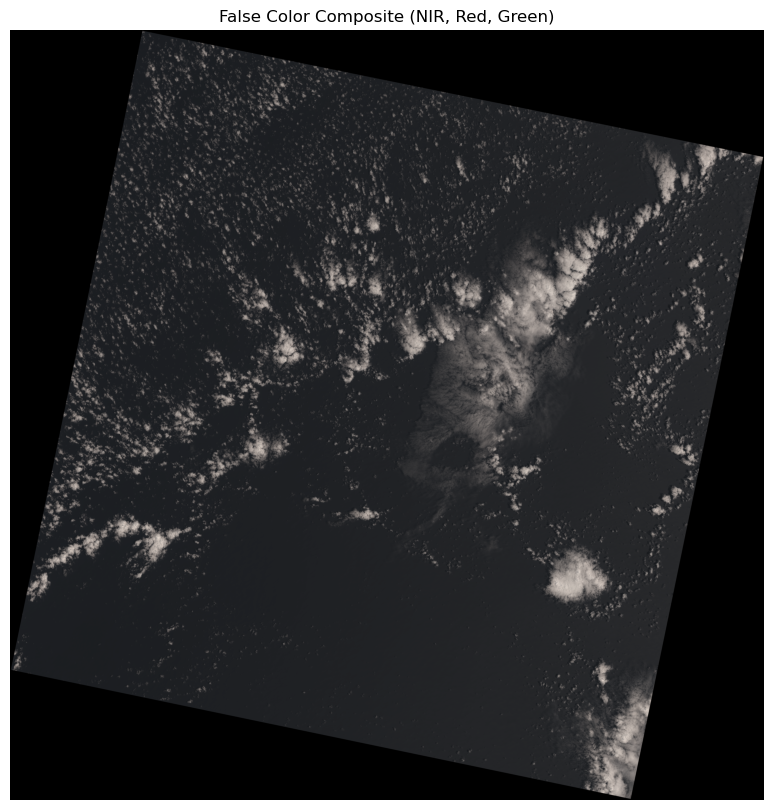

NameError: name 'profile' is not defined

In [20]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths to your TIFF files
band5_path = 'Landsat8_Images/extracted/LC08_L1GT_072043_20170501_20201016_02_T2_B5.TIF'  # Near-Infrared
band4_path = 'Landsat8_Images/extracted/LC08_L1GT_072043_20170501_20201016_02_T2_B4.TIF'  # Red
band3_path = 'Landsat8_Images/extracted/LC08_L1GT_072043_20170501_20201016_02_T2_B3.TIF'  # Green

# Open the bands
with rasterio.open(band5_path) as band5:
    b5 = band5.read(1)

with rasterio.open(band4_path) as band4:
    b4 = band4.read(1)

with rasterio.open(band3_path) as band3:
    b3 = band3.read(1)

# Stack bands into a single 3D array (R, G, B)
false_color = np.dstack((b5, b4, b3))

# Optional: Stretch the values to [0, 1] for display
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

false_color_norm = normalize(false_color)

# Display the false color image
plt.figure(figsize=(10, 10))
plt.imshow(false_color_norm)
plt.title('False Color Composite (NIR, Red, Green)')
plt.axis('off')
plt.show()


# Save the new stacked image
output_path = 'Landsat8_Images/'

# Update profile for 3 bands
profile.update(
    count=3,  # 3 bands (R, G, B)
    dtype=rasterio.uint16  # Keep same dtype or adjust if needed
)

# Save
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(false_color)

print(f"False color image saved to: {output_path}")


In [22]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths to your TIFF files
band5_path = 'Landsat8_Images/extracted/LC08_L1GT_072043_20170501_20201016_02_T2_B5.TIF'  # Near-Infrared
band4_path = 'Landsat8_Images/extracted/LC08_L1GT_072043_20170501_20201016_02_T2_B4.TIF'  # Red
band3_path = 'Landsat8_Images/extracted/LC08_L1GT_072043_20170501_20201016_02_T2_B3.TIF'  # Green

# Open the bands
with rasterio.open(band5_path) as band5:
    b5 = band5.read(1)
    profile = band5.profile  # Save metadata to reuse later

with rasterio.open(band4_path) as band4:
    b4 = band4.read(1)

with rasterio.open(band3_path) as band3:
    b3 = band3.read(1)

# Stack bands into (bands, rows, columns)
false_color = np.stack((b5, b4, b3))

# Optional: Normalize if you want it prettier for visualization (not for saving raw data)
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Save the new stacked image
output_path = 'Landsat8_Images/false_color_composite.tif'


# Update profile for 3 bands
profile.update(
    count=3,  # 3 bands (R, G, B)
    dtype=rasterio.uint16  # Keep same dtype or adjust if needed
)

# Save
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(false_color)

print(f"False color image saved to: {output_path}")


False color image saved to: Landsat8_Images/false_color_composite.tif


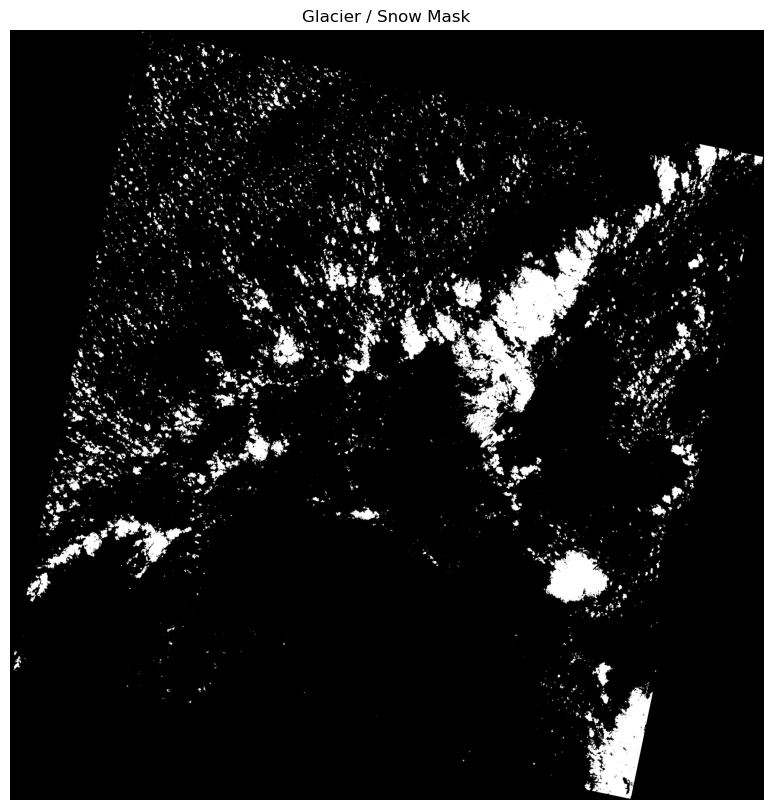

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the TIFF
with rasterio.open('Landsat8_Images/false_color_composite.tif') as src:
    img = src.read()  # Shape: (bands, height, width)
    profile = src.profile

# Normalize bands to 0-1
img = img.astype(np.float32)
img /= img.max()

# Let's say Band 1 (Red), Band 2 (Green), Band 3 (Blue)
# You can pick based on your composite setup!

red = img[0]
green = img[1]
blue = img[2]

# Define a basic glacier mask: high reflectance in visible bands
glacier_mask = (blue > 0.3) & (green > 0.3) & (red > 0.3)

# Visualize the classification
plt.figure(figsize=(10, 10))
plt.imshow(glacier_mask, cmap='gray')
plt.title('Glacier / Snow Mask')
plt.axis('off')
plt.show()


In [10]:
import mimetypes

# Check the MIME type of the file
file_path = 'Landsat8_Images/LC08_L1GT_072043_20170501_20201016_02_T2 (2).tar'
mime_type, _ = mimetypes.guess_type(file_path)

print(f"File MIME type: {mime_type}")

File MIME type: application/x-tar


In [13]:
import tarfile

file_path = r"C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC08_L1GT_072043_20170501_20201016_02_T2 (2).tar"
extract_path = r"C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/extracted"

# Open as a tar file
with tarfile.open(file_path, "r") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete!")


Extraction complete!


In [38]:
import zipfile
import os

# Path to your ZIP file
zip_file_path = r'C:\Users\couse\OneDrive - Ulster University\Postgrad\PGCert Remote Sensing and GIS\EGM 722\EGM722_Project\Landsat8_Images\LC80720432017121LGN00.zip'

# Check if the ZIP file exists
if os.path.exists(zip_file_path):
    try:
        # Open the ZIP file for reading
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # List the files inside the ZIP file
            print("Contents of the ZIP file:")
            zip_ref.printdir()

            # Extract all contents of the ZIP file to a specified directory
            extract_dir = r'C:\path\to\your\desired\extraction\folder'
            zip_ref.extractall(extract_dir)

            print(f"Files extracted to: {extract_dir}")
    except zipfile.BadZipFile:
        print("The file is not a valid ZIP file.")
else:
    print("The specified ZIP file does not exist.")


The file is not a valid ZIP file.


In [40]:
import magic

file_path = 'C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip'

mime = magic.Magic(mime=True)
file_mime_type = mime.from_file(file_path)

print(f"MIME type of the file: {file_mime_type}")


MIME type of the file: application/x-tar


In [41]:
import mimetypes

file_path = 'C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip'
mime_type, encoding = mimetypes.guess_type(file_path)

print(f'MIME type: {mime_type}, Encoding: {encoding}')

MIME type: application/x-zip-compressed, Encoding: None


In [43]:
with open('C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip', 'rb') as f:
    signature = f.read(4)
    print(f"File signature: {signature.hex()}")



File signature: 2e2f2e2f


In [44]:
import zipfile

file_path = 'C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip'

try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.testzip()  # Test the file's integrity
        print("The ZIP file is valid!")
except zipfile.BadZipFile:
    print(f"Error: The file '{file_path}' is not a valid ZIP file.")
except Exception as e:
    print(f"An error occurred: {e}")


Error: The file 'C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip' is not a valid ZIP file.


In [45]:
import shutil

shutil.unpack_archive('C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip', 'C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/extracted')


ReadError: C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC80720432017121LGN00.zip is not a zip file

In [33]:
import tarfile

file_path = 'Landsat8_Images/LC80720432017121LGN00.zip'

with open(file_path, 'rb') as file:
    file_header = file.read(4)  # Read the first 4 bytes
    print(file_header)

try:
    with tarfile.open(file_path, 'r:gz') as tar_ref:
        tar_ref.extractall('downloads/extracted/')
    print("✅ Extraction successful!")
except tarfile.TarError:
    print(f"❌ {file_path} is not a valid tar file.")
except Exception as e:
    print(f"❌ An error occurred: {e}")


b'././'
❌ Landsat8_Images/LC80720432017121LGN00.zip is not a valid tar file.


b'././'


In [ ]:
import requests
import os

# Request the download URL
download_options = api.download_request(
    dataset="landsat_ot_c2_l1",
    entity_id="LC80720432017121LGN00",
    product_id="5e81f14f92acf9ef",
    api_key=api_key
)

# Safely check if availableDownloads exists and is not empty
if download_options['data'] and 'availableDownloads' in download_options['data'] and len(download_options['data']['availableDownloads']) > 0:
    download_url = download_options['data']['availableDownloads'][0]['url']
    
    download_dir = "C:/Users/couse/Downloads"  # <-- Set your folder here
    os.makedirs(download_dir, exist_ok=True)
    
    filename = "downloaded_scene.zip"
    file_path = os.path.join(download_dir, filename)
    
    print(f"Downloading file to {file_path}...")
    response = requests.get(download_url)
    
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Download completed: {file_path}")
    else:
        print(f"Failed to download. HTTP Status Code: {response.status_code}")
else:
    print("No available downloads were found for this entity.")

In [ ]:
help(api.download_request)

In [ ]:
help(api.payloads)